In [1]:
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


In [2]:
%matplotlib inline

In [3]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, 
                  pos = None, parent = None):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node of current branch
       width: horizontal space allocated for this branch - avoids overlap with other branches
       vert_gap: gap between levels of hierarchy
       vert_loc: vertical location of root
       xcenter: horizontal location of root
       pos: a dict saying where all nodes go if they have been assigned
       parent: parent of this branch.'''
    if pos == None:
        pos = {root:(xcenter,vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    neighbors = list(G.neighbors(root)) 
    if parent != None:   #this should be removed for directed graphs.
        neighbors.remove(parent)  #if directed, then parent not in neighbors.
    if len(neighbors)!=0:
        dx = width/len(neighbors) 
        nextx = xcenter - width/2 - dx/2
        for neighbor in neighbors:
            nextx += dx
            pos = hierarchy_pos(G,neighbor, width = dx, vert_gap = vert_gap, 
                                vert_loc = vert_loc-vert_gap, xcenter=nextx, pos=pos, 
                                parent = root)
    return pos

In [4]:
pwd

'/home/gmarconi/coding/python/poincare-embeddings/notebooks'

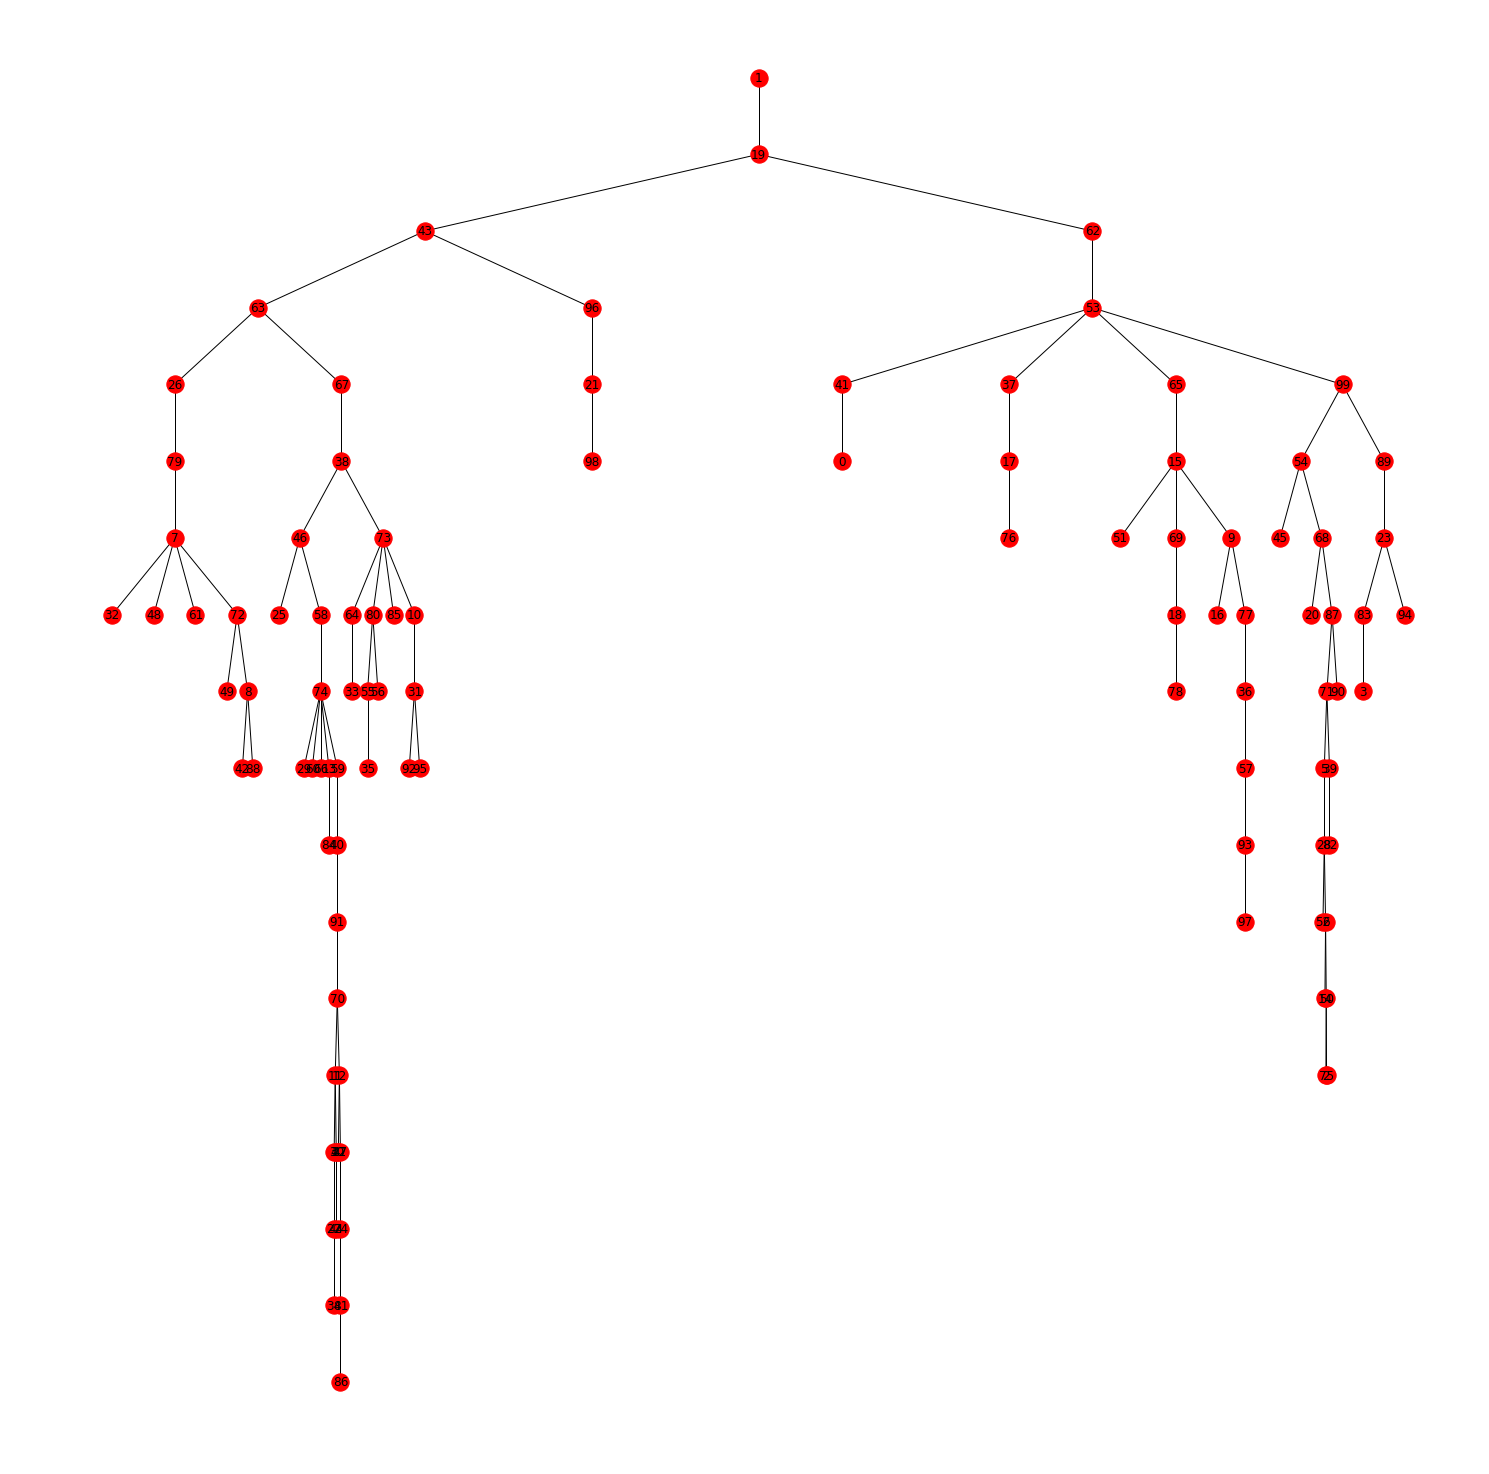

In [5]:
G = nx.random_tree(100, 7)
nodes  = [node[0] for node in G.adjacency()]
plt.figure(figsize=(20,20))
pos = hierarchy_pos(G,1)    
nx.draw(G, pos=pos, with_labels=True)

In [345]:
root = 1
start_nnodes = G.number_of_nodes()
leaves_idx = G.number_of_nodes()
max_child = 10
dim = 300

X = []

for node in nodes:

    G.add_node(node, name=str(node), feature=-1)
    if len(G[node]) == 1 and (node != root):
        nchildren = np.random.randint(1, max_child+1)
        mean = np.zeros(dim)
        mean[min(dim-1, leaves_idx-start_nnodes)] = 10
        for child in range(nchildren):
            G.add_node(leaves_idx, name=str(node)+'_'+str(child), feature=(leaves_idx-start_nnodes))
            G.add_edge(node, leaves_idx)
            leaves_idx += 1
            feature = np.random.multivariate_normal(mean=mean, cov=np.eye(mean.size))
            X.append(feature)
        print("Added %d leaves to node %d" % (nchildren, node))
X = np.asarray(X)
print("\nAdded %d leaves" % (leaves_idx - start_nnodes))

Added 9 leaves to node 0
Added 8 leaves to node 2
Added 6 leaves to node 3
Added 1 leaves to node 14
Added 2 leaves to node 16
Added 6 leaves to node 20
Added 4 leaves to node 22
Added 7 leaves to node 25
Added 6 leaves to node 29
Added 4 leaves to node 32
Added 4 leaves to node 33
Added 3 leaves to node 34
Added 3 leaves to node 35
Added 2 leaves to node 42
Added 1 leaves to node 44
Added 7 leaves to node 45
Added 10 leaves to node 48
Added 2 leaves to node 49
Added 9 leaves to node 51
Added 2 leaves to node 52
Added 2 leaves to node 56
Added 10 leaves to node 60
Added 1 leaves to node 61
Added 4 leaves to node 66
Added 6 leaves to node 75
Added 8 leaves to node 76
Added 10 leaves to node 78
Added 6 leaves to node 82
Added 8 leaves to node 84
Added 2 leaves to node 85
Added 10 leaves to node 86
Added 10 leaves to node 88
Added 8 leaves to node 90
Added 1 leaves to node 92
Added 3 leaves to node 94
Added 10 leaves to node 95
Added 10 leaves to node 97
Added 2 leaves to node 98

Added 2

In [346]:
K = np.dot(X,X.T)
print(K.shape)

(207, 207)


In [12]:
nx.write_weighted_edgelist(G, "../data/synth_graph_simple.tsv", delimiter='\t')
nx.write_gpickle(G, '../data/synth_graph_simple.p')
#np.save("synth_features.npy", X)

In [348]:
ls

data.py      mammals.pth   rsgd.py             test.dot         wn-nouns.jpg
embed.py     model.py      synth_features.npy  train-nouns.sh*  wordnet/
example.sh*  __pycache__/  synth_graph.p       train.py
LICENSE      README.org    synth_graph.tsv     Untitled.ipynb


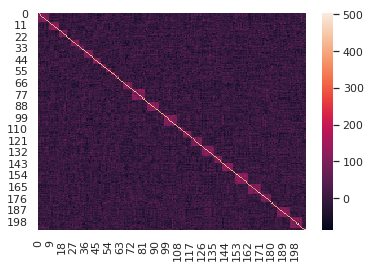

In [349]:
import seaborn as sns; sns.set()
ax = sns.heatmap(K)

In [350]:
from itertools import count
from collections import defaultdict as ddict

def parse_seperator(line, length, sep='\t'):
    d = line.strip().split(sep)
    if len(d) == length:
        w = 1
    elif len(d) == length + 1:
        w = int(d[-1])
        d = d[:-1]
    else:
        raise RuntimeError(f'Malformed input ({line.strip()})')
    return tuple(d) + (w,)


def parse_tsv(line, length=2):
    return parse_seperator(line, length, '\t')

def parse_space(line, length=2):
    return parse_seperator(line, length, ' ')


def Gintdict_to_list(d, Graph):
    arr = [None for _ in range(len(d))]
    for v, i in d.items():
        arr[i] = { **{'label':v}, **G.nodes[int(v)] }
    assert not any(x is None for x in arr)
    return arr

In [351]:
ecount = count()
enames = ddict(ecount.__next__)
subs=[]
for line in nx.generate_edgelist(G, data=False):
    i, j, w = parse_space(line)
    print(i,j,w)
    if i == j:
        continue
    subs.append((enames[i], enames[j], w))
    objects = Gintdict_to_list(dict(enames), G)

0 41 1
0 100 1
0 101 1
0 102 1
0 103 1
0 104 1
0 105 1
0 106 1
0 107 1
0 108 1
1 19 1
2 50 1
2 109 1
2 110 1
2 111 1
2 112 1
2 113 1
2 114 1
2 115 1
2 116 1
3 83 1
3 117 1
3 118 1
3 119 1
3 120 1
3 121 1
3 122 1
4 27 1
4 11 1
5 28 1
5 71 1
6 14 1
6 50 1
6 28 1
7 32 1
7 48 1
7 61 1
7 72 1
7 79 1
8 42 1
8 88 1
8 72 1
9 16 1
9 77 1
9 15 1
10 31 1
10 73 1
11 30 1
11 70 1
12 22 1
12 47 1
12 70 1
13 84 1
13 74 1
14 123 1
15 51 1
15 69 1
15 65 1
16 124 1
16 125 1
17 76 1
17 37 1
18 78 1
18 69 1
19 43 1
19 62 1
20 68 1
20 126 1
20 127 1
20 128 1
20 129 1
20 130 1
20 131 1
21 98 1
21 96 1
22 132 1
22 133 1
22 134 1
22 135 1
23 83 1
23 94 1
23 89 1
24 81 1
24 47 1
25 46 1
25 136 1
25 137 1
25 138 1
25 139 1
25 140 1
25 141 1
25 142 1
26 79 1
26 63 1
27 34 1
28 52 1
29 74 1
29 143 1
29 144 1
29 145 1
29 146 1
29 147 1
29 148 1
30 44 1
31 92 1
31 95 1
32 149 1
32 150 1
32 151 1
32 152 1
33 64 1
33 153 1
33 154 1
33 155 1
33 156 1
34 157 1
34 158 1
34 159 1
35 55 1
35 160 1
35 161 1
35 162 1
36 57 

In [358]:
enames

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x7f8e2a4fed08>,
            {'0': 0,
             '41': 1,
             '100': 2,
             '101': 3,
             '102': 4,
             '103': 5,
             '104': 6,
             '105': 7,
             '106': 8,
             '107': 9,
             '108': 10,
             '1': 11,
             '19': 12,
             '2': 13,
             '50': 14,
             '109': 15,
             '110': 16,
             '111': 17,
             '112': 18,
             '113': 19,
             '114': 20,
             '115': 21,
             '116': 22,
             '3': 23,
             '83': 24,
             '117': 25,
             '118': 26,
             '119': 27,
             '120': 28,
             '121': 29,
             '122': 30,
             '4': 31,
             '27': 32,
             '11': 33,
             '5': 34,
             '28': 35,
             '71': 36,
             '6': 37,
             '14': 38,
            

In [360]:
objects

[{'label': '0', 'name': '0', 'feature': -1},
 {'label': '41', 'name': '41', 'feature': -1},
 {'label': '100', 'name': '0_0', 'feature': 0},
 {'label': '101', 'name': '0_1', 'feature': 1},
 {'label': '102', 'name': '0_2', 'feature': 2},
 {'label': '103', 'name': '0_3', 'feature': 3},
 {'label': '104', 'name': '0_4', 'feature': 4},
 {'label': '105', 'name': '0_5', 'feature': 5},
 {'label': '106', 'name': '0_6', 'feature': 6},
 {'label': '107', 'name': '0_7', 'feature': 7},
 {'label': '108', 'name': '0_8', 'feature': 8},
 {'label': '1', 'name': '1', 'feature': -1},
 {'label': '19', 'name': '19', 'feature': -1},
 {'label': '2', 'name': '2', 'feature': -1},
 {'label': '50', 'name': '50', 'feature': -1},
 {'label': '109', 'name': '2_0', 'feature': 9},
 {'label': '110', 'name': '2_1', 'feature': 10},
 {'label': '111', 'name': '2_2', 'feature': 11},
 {'label': '112', 'name': '2_3', 'feature': 12},
 {'label': '113', 'name': '2_4', 'feature': 13},
 {'label': '114', 'name': '2_5', 'feature': 14},

In [13]:
filepath = "../data/synth_graph_simple.tsv"
with open(filepath) as fp:
    lines = fp.read().splitlines()
with open(filepath, "w") as fp:
    for line in lines:
        print(line + "\t1", file=fp)